# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics


from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# using SQLite Table to read data.
con = sqlite3.connect('/content/drive/My Drive/Colab Notebooks/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [7]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [8]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.


In [21]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This book was purchased as a birthday gift for a  year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is a great product It is very healthy for all of our dogs and it is the first food that they all love to eat It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 348260/348260 [02:48<00:00, 2067.35it/s]


In [25]:
preprocessed_reviews[1500]

'great product healthy dogs first food love eat helped older dog lose weight year old lab gain weight needed healthy'

In [26]:
len(preprocessed_reviews)

348260

In [0]:
final["preprocessed_reviews"]=preprocessed_reviews

In [28]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,preprocessed_reviews
138702,150520,0006641040,ADBFSA9KTQANE,"James L. Hammock ""Pucks Buddy""",0,0,1,1256688000,Great Gift,This book was purchased as a birthday gift for...,book purchased birthday gift year old boy sque...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",daughter loves really rosie books introduced r...
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,0,1129507200,awesome book poor size,This is one of the best children's books ever ...,one best children books ever written mini vers...
138692,150510,0006641040,AM1MNZMYMS7D8,Dr. Joshua Grossman,0,0,1,1348358400,Professional Mentoring,TITLE: Chicken Soup with Rice<br />AUTHOR: Mau...,title chicken soup riceauthor maurice sendakre...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...


In [29]:
final.shape

(348260, 11)

In [0]:
final=final.drop(["Id","ProductId","UserId","ProfileName","HelpfulnessNumerator"],axis=1)

In [0]:
final_last=final.drop(["HelpfulnessDenominator","Time","Summary","Text"],axis=1)

In [32]:
final_last.shape

(348260, 2)

In [33]:
final_last.head()

,Score,preprocessed_reviews
138702,1,book purchased birthday gift year old boy sque...
138707,1,daughter loves really rosie books introduced r...
138708,0,one best children books ever written mini vers...
138692,1,title chicken soup riceauthor maurice sendakre...
138689,1,fun way children learn months year learn poems...


In [0]:
X=final_last["preprocessed_reviews"]
Y=final_last["Score"]

In [35]:
X

138702    book purchased birthday gift year old boy sque...
138707    daughter loves really rosie books introduced r...
138708    one best children books ever written mini vers...
138692    title chicken soup riceauthor maurice sendakre...
138689    fun way children learn months year learn poems...
138690    great little book read aloud nice rhythm well ...
138691    book poetry months year goes month cute little...
138688    grew reading sendak books watching really rosi...
138697    book family favorite read children small order...
138709    junei saw charming groupof roses beginto droop...
138696    great book adorable illustrations true classic...
138695    remembered book childhood got kids good rememb...
138694    set aside least hour day read son point consid...
138693    charming rhyming book describes circumstances ...
138681    book favorite mine since able read one first i...
138703    year old daughter brought book home school lib...
138680    wonderful little book loved ye

In [0]:
from sklearn.model_selection import train_test_split

## [1]Working With BAG OF WORDS

### Applying KNN kd-tree on BOW

In [0]:
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(X[:20000], Y[:20000], test_size=0.33) 
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting

In [38]:
#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# choosing these numebrs min_df=10, max_features=500
count_vect = CountVectorizer(ngram_range=(1,1), min_df=10, max_features=500)
X_train_bow_bigram = count_vect.fit_transform(X_train)
X_cv_bow_bigram = count_vect.transform(X_cv)
X_test_bow_bigram = count_vect.transform(X_test)
print("After vectorizations")
print(X_train_bow_bigram.shape, y_train.shape)
print(X_cv_bow_bigram.shape,y_cv.shape)
print(X_test_bow_bigram.shape, y_test.shape)
print("="*100)
print("the type of count vectorizer ",type(X_train_bow_bigram))
print("the number of unique words in train", X_train_bow_bigram.get_shape()[1])

After vectorizations
(8978, 500) (8978,)
(4422, 500) (4422,)
(6600, 500) (6600,)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique words in train 500


### Applying Gridsearch to do hyperparameter tuning

In [39]:
#Applying Gridsearch to do hyperparameter tuning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

#Applying kd_tree algorithm in knn model
knn_model=KNeighborsClassifier(algorithm='kd_tree',n_jobs=-1)

parameters={'n_neighbors':[1,5,10,15,21,31,41]}
clf=GridSearchCV(knn_model,parameters,cv=10,scoring='roc_auc',n_jobs=-1)

#converting sparse matrices into dense as Kd-tree algo takes dense matrices

X_train_bow_bigram=X_train_bow_bigram.toarray()

clf.fit(X_train_bow_bigram, y_train)




GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': [1, 5, 10, 15, 21, 31, 41]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

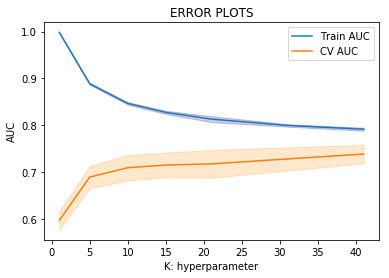

In [40]:
train_auc=clf.cv_results_["mean_train_score"]
train_auc_std=clf.cv_results_["std_train_score"]
cv_auc=clf.cv_results_["mean_test_score"]
cv_auc_std=clf.cv_results_["std_test_score"]

K=[1,5,10,15,21,31,41]
plt.plot(K, train_auc , label="Train AUC")
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Testing with test data

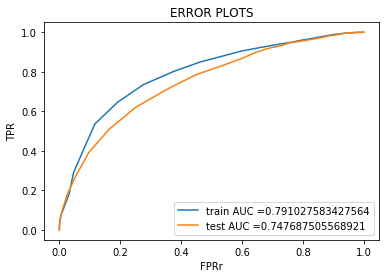

Train confusion matrix
[[  78 1293]
 [  29 7578]]
Test confusion matrix
[[  60  972]
 [  30 5538]]


In [41]:
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=50 ,algorithm='kd_tree')
neigh.fit(X_train_bow_bigram, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
#converting X_test data into dense matrices as kd_tree works with dense matrices
X_test_bow_bigram=X_test_bow_bigram.toarray()
train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_bow_bigram)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_bow_bigram)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPRr")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(X_train_bow_bigram)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(X_test_bow_bigram)))

Heatmap of train confusion matrix


Text(33.0, 0.5, 'Actual Class')

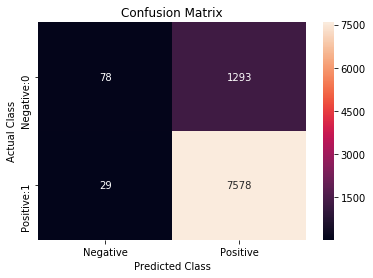

In [44]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_BOW = confusion_matrix(y_train, neigh.predict(X_train_bow_bigram))

df_cm=pd.DataFrame(confusion_matrix_train_BOW,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of test confusion matrix


Text(33.0, 0.5, 'Actual Class')

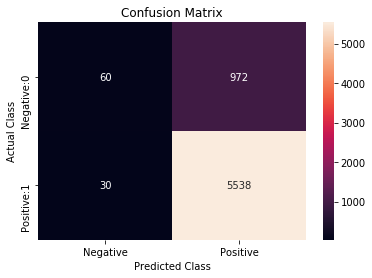

In [46]:
print("Heatmap of test confusion matrix")
import seaborn as sns
confusion_matrix_test_BOW = confusion_matrix(y_test, neigh.predict(X_test_bow_bigram))

df_cm=pd.DataFrame(confusion_matrix_test_BOW,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

In [0]:
#Accuracy for KNN(kd_tree) model with BOW is 74.3%

### Applying KNN brute force on BOW

In [0]:
X_train,X_test,y_train,y_test=train_test_split(X[:100000],Y[:100000],test_size=0.33,random_state=1)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting

In [49]:
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
X_train_bow_bigram = count_vect.fit_transform(X_train)
X_cv_bow_bigram = count_vect.transform(X_cv)
X_test_bow_bigram = count_vect.transform(X_test)
print("After vectorizations")
print(X_train_bow_bigram.shape, y_train.shape)
print(X_cv_bow_bigram.shape,y_cv.shape)
print(X_test_bow_bigram.shape, y_test.shape)
print("="*100)
print("the type of count vectorizer ",type(X_train_bow_bigram))
print("the number of unique words in train", X_train_bow_bigram.get_shape()[1])

After vectorizations
(44890, 500) (44890,)
(22110, 500) (22110,)
(33000, 500) (33000,)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique words in train 500


### Applying Gridsearch to do hyperparameter tuning

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
#now lets apply brute force algorithm instead of kd_tree 

#Applying Gridsearch to do hyperparameter tuning


knn_model_brute=KNeighborsClassifier(algorithm='brute',n_jobs=-1)
parameters={'n_neighbors':[10,21,31,41,51,61]}
clf_brute=GridSearchCV(knn_model_brute,parameters,cv=10,scoring='roc_auc',n_jobs=-1)



clf_brute.fit(X_train_bow_bigram, y_train)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': [10, 21, 31, 41, 51, 61]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

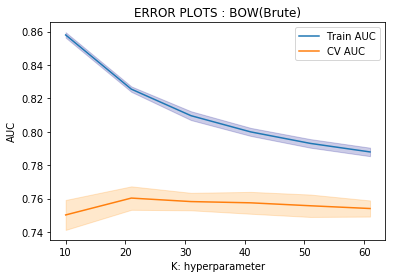

In [51]:
train_auc=clf_brute.cv_results_["mean_train_score"]
train_auc_std=clf_brute.cv_results_["std_train_score"]
cv_auc=clf_brute.cv_results_["mean_test_score"]
cv_auc_std=clf_brute.cv_results_["std_test_score"]

K=[10,21,31,41,51,61]
plt.plot(K, train_auc , label="Train AUC")
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS : BOW(Brute)")
plt.show()

### Testing with test data

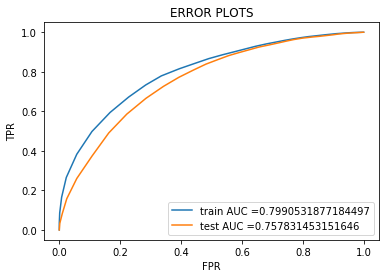

Train confusion matrix
[[ 1204  5450]
 [  843 37393]]
Test confusion matrix
[[  837  4052]
 [  689 27422]]


In [52]:
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=45,algorithm='brute')
neigh.fit(X_train_bow_bigram, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
#converting X_test data into dense matrices as kd_tree works with dense matrices
#X_test_bow_bigram=X_test_bow_bigram.toarray()
train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_bow_bigram)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_bow_bigram)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(X_train_bow_bigram)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(X_test_bow_bigram)))

Heatmap of train confusion matrix


Text(33.0, 0.5, 'Actual Class')

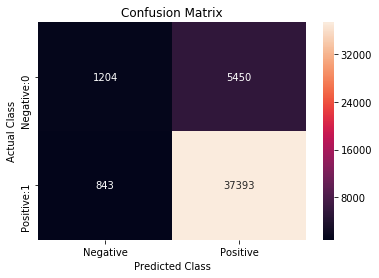

In [54]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_BOW = confusion_matrix(y_train, neigh.predict(X_train_bow_bigram))

df_cm=pd.DataFrame(confusion_matrix_train_BOW,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of test confusion matrix


Text(33.0, 0.5, 'Actual Class')

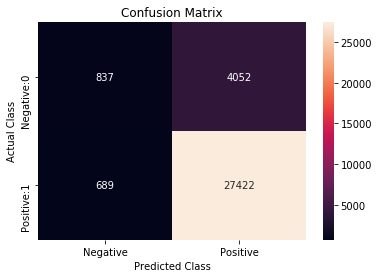

In [55]:
print("Heatmap of test confusion matrix")
import seaborn as sns
confusion_matrix_test_BOW = confusion_matrix(y_test, neigh.predict(X_test_bow_bigram))

df_cm=pd.DataFrame(confusion_matrix_test_BOW,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

In [0]:
#Accuracy for KNN(brute force) model with BOW is 75.8%

## [2]Working With TFIDF

### Applying KNN kd-tree on TFIDF

In [0]:
#First applying with kd_tree algorithm
X_train_kd,X_test_kd,y_train_kd,y_test_kd=train_test_split(X[:20000],Y[:20000],test_size=0.33,random_state=1)
X_train_kd, X_cv_kd, y_train_kd, y_cv_kd = train_test_split(X_train_kd, y_train_kd, test_size=0.33) # this is random splitting

In [58]:
tf_idf_vect_kd = TfidfVectorizer(ngram_range=(1,2), max_features=500)
tf_idf_vect_kd.fit(X_train_kd)
print("some sample features(unique words in the corpus)",tf_idf_vect_kd.get_feature_names()[0:10])
print('='*50)

X_train_tfidf_kd = tf_idf_vect_kd.transform(X_train_kd)
X_cv_tfidf_kd = tf_idf_vect_kd.transform(X_cv_kd)
X_test_tfidf_kd = tf_idf_vect_kd.transform(X_test_kd)
print(X_train_tfidf_kd.shape, y_train_kd.shape)
print(X_cv_tfidf_kd.shape , y_cv_kd.shape)
print(X_test_tfidf_kd.shape, y_test_kd.shape)
print("="*100)
print("the type of count vectorizer ",type(X_train_tfidf_kd))
print("the number of unique words in train", X_train_tfidf_kd.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'ago', 'almost', 'already', 'also', 'although']
(8978, 500) (8978,)
(4422, 500) (4422,)
(6600, 500) (6600,)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique words in train 500


### Applying Gridsearch to do hyperparameter tuning

In [59]:
#Applying Gridsearch to do hyperparameter tuning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

#converting sparse matrices into dense as Kd-tree algo takes dense matrices
X_train_tfidf_kd=X_train_tfidf_kd.toarray()

knn_model_tfidf_kd=KNeighborsClassifier(algorithm='kd_tree' ,n_jobs=-1)
parameters={'n_neighbors':[10,15,21,31,41,51,61]}
clf_tfidf_kd=GridSearchCV(knn_model_tfidf_kd,parameters,cv=10,scoring='roc_auc',n_jobs=-1)
clf_tfidf_kd.fit(X_train_tfidf_kd, y_train_kd)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': [10, 15, 21, 31, 41, 51, 61]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

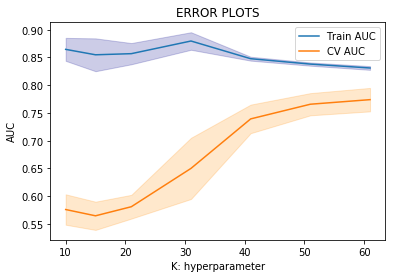

In [60]:
train_auc_tfidf_kd= clf_tfidf_kd.cv_results_['mean_train_score']
train_auc_std_tfidf_kd= clf_tfidf_kd.cv_results_['std_train_score']
cv_auc_tfidf_kd = clf_tfidf_kd.cv_results_['mean_test_score'] 
cv_auc_std_tfidf_kd= clf_tfidf_kd.cv_results_['std_test_score']
K=[10,15,21,31,41,51,61]
plt.plot(K, train_auc_tfidf_kd, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc_tfidf_kd - train_auc_std_tfidf_kd,train_auc_tfidf_kd + train_auc_std_tfidf_kd,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc_tfidf_kd, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc_tfidf_kd - cv_auc_std_tfidf_kd,cv_auc_tfidf_kd + cv_auc_std_tfidf_kd,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Testing with test data

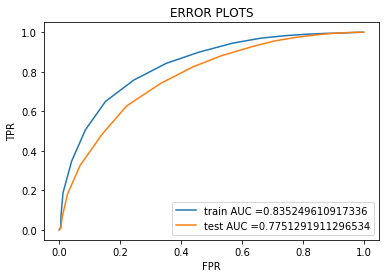

Train confusion matrix
[[   0 1411]
 [   0 7567]]
Test confusion matrix
[[   0  994]
 [   0 5606]]


In [61]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh_tfidf_kd = KNeighborsClassifier(n_neighbors=60 ,n_jobs=-1,algorithm='kd_tree')
neigh_tfidf_kd.fit(X_train_tfidf_kd, y_train_kd)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

#converting sparse matrices into dense as Kd-tree algo takes dense matrices

X_test_tfidf_kd=X_test_tfidf_kd.toarray()

train_fpr_tfidf, train_tpr_tfidf, thresholds_tfidf = roc_curve(y_train_kd, neigh_tfidf_kd.predict_proba(X_train_tfidf_kd)[:,1])
test_fpr_tfidf, test_tpr_tfidf, thresholds_tfidf = roc_curve(y_test_kd, neigh_tfidf_kd.predict_proba(X_test_tfidf_kd)[:,1])

plt.plot(train_fpr_tfidf, train_tpr_tfidf, label="train AUC ="+str(auc(train_fpr_tfidf, train_tpr_tfidf)))
plt.plot(test_fpr_tfidf, test_tpr_tfidf, label="test AUC ="+str(auc(test_fpr_tfidf, test_tpr_tfidf)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train_kd, neigh_tfidf_kd.predict(X_train_tfidf_kd)))
print("Test confusion matrix")
print(confusion_matrix(y_test_kd, neigh_tfidf_kd.predict(X_test_tfidf_kd)))

Heatmap of train confusion matrix


Text(33.0, 0.5, 'Actual Class')

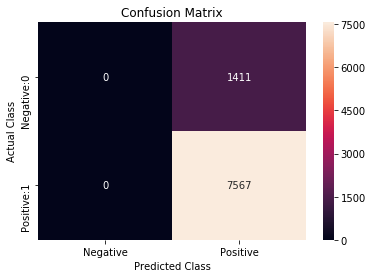

In [64]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_TFIDF = confusion_matrix(y_train_kd, neigh_tfidf_kd.predict(X_train_tfidf_kd))

df_cm=pd.DataFrame(confusion_matrix_train_TFIDF,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of test confusion matrix


Text(33.0, 0.5, 'Actual Class')

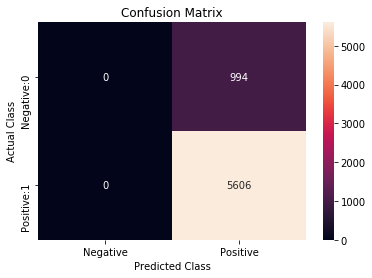

In [65]:
print("Heatmap of test confusion matrix")
import seaborn as sns
confusion_matrix_test_TFIDF = confusion_matrix(y_test_kd, neigh_tfidf_kd.predict(X_test_tfidf_kd))

df_cm=pd.DataFrame(confusion_matrix_test_TFIDF,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

In [0]:
#Accuracy for KNN(kd-tree) model with TFIDF is 77.5%

### Applying KNN brute force on TFIDF

In [67]:
#Applying brute force on TFIDF

tf_idf_vect_brute = TfidfVectorizer(ngram_range=(1,2), max_features=500)
tf_idf_vect_brute.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect_brute.get_feature_names()[0:10])
print('='*50)

X_train_tfidf_brute = tf_idf_vect_brute.transform(X_train)
X_cv_tfidf_brute = tf_idf_vect_brute.transform(X_cv)
X_test_tfidf_brute = tf_idf_vect_brute.transform(X_test)
print(X_train_tfidf_brute.shape, y_train.shape)
print(X_cv_tfidf_brute.shape , y_cv.shape)
print(X_test_tfidf_brute.shape, y_test.shape)
print("="*100)
print("the type of count vectorizer ",type(X_train_tfidf_brute))
print("the number of unique words in train", X_train_tfidf_brute.get_shape()[1])


some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'adding', 'ago', 'almost', 'along', 'already']
(44890, 500) (44890,)
(22110, 500) (22110,)
(33000, 500) (33000,)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique words in train 500


### Applying Gridsearch to do hyperparameter tuning

In [68]:

knn_model_tfidf_brute=KNeighborsClassifier(algorithm='brute' ,n_jobs=-1)
parameters={'n_neighbors':[10,15,21,31,41,51,61,71]}
clf_tfidf_brute=GridSearchCV(knn_model_tfidf_brute,parameters,cv=10,scoring='roc_auc',n_jobs=-1)
clf_tfidf_brute.fit(X_train_tfidf_brute, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': [10, 15, 21, 31, 41, 51, 61, 71]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

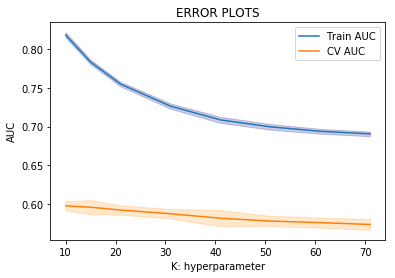

In [69]:
train_auc_tfidf_brute= clf_tfidf_brute.cv_results_['mean_train_score']
train_auc_std_tfidf_brute= clf_tfidf_brute.cv_results_['std_train_score']
cv_auc_tfidf_brute = clf_tfidf_brute.cv_results_['mean_test_score'] 
cv_auc_std_tfidf_brute= clf_tfidf_brute.cv_results_['std_test_score']
K=[10,15,21,31,41,51,61,71]
plt.plot(K, train_auc_tfidf_brute, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc_tfidf_brute - train_auc_std_tfidf_brute,train_auc_tfidf_brute + train_auc_std_tfidf_brute,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc_tfidf_brute, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc_tfidf_brute - cv_auc_std_tfidf_brute,cv_auc_tfidf_brute + cv_auc_std_tfidf_brute,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Testing with test data

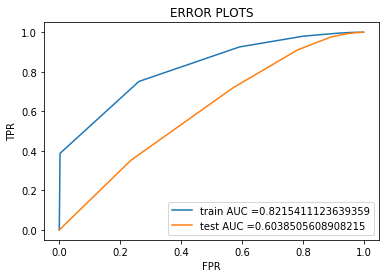

Train confusion matrix
[[  607  6047]
 [  214 38022]]
Test confusion matrix
[[  269  4620]
 [  210 27901]]


In [70]:
#Testing with test data

neigh_tfidf_brute = KNeighborsClassifier(n_neighbors=10 ,algorithm='brute')
neigh_tfidf_brute.fit(X_train_tfidf_brute, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

#converting sparse matrices into dense as Kd-tree algo takes dense matrices

#X_test_tfidf_kd=X_test_tfidf_kd.toarray()

train_fpr_tfidf, train_tpr_tfidf, thresholds_tfidf = roc_curve(y_train, neigh_tfidf_brute.predict_proba(X_train_tfidf_brute)[:,1])
test_fpr_tfidf, test_tpr_tfidf, thresholds_tfidf = roc_curve(y_test, neigh_tfidf_brute.predict_proba(X_test_tfidf_brute)[:,1])

plt.plot(train_fpr_tfidf, train_tpr_tfidf, label="train AUC ="+str(auc(train_fpr_tfidf, train_tpr_tfidf)))
plt.plot(test_fpr_tfidf, test_tpr_tfidf, label="test AUC ="+str(auc(test_fpr_tfidf, test_tpr_tfidf)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh_tfidf_brute.predict(X_train_tfidf_brute)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh_tfidf_brute.predict(X_test_tfidf_brute)))

Heatmap of train confusion matrix


Text(33.0, 0.5, 'Actual Class')

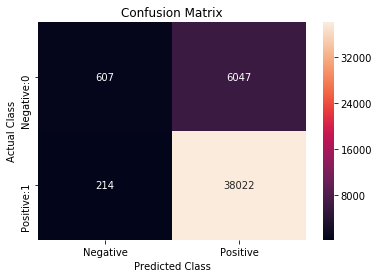

In [72]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_TFIDF = confusion_matrix(y_train, neigh_tfidf_brute.predict(X_train_tfidf_brute))

df_cm=pd.DataFrame(confusion_matrix_train_TFIDF,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of test confusion matrix


Text(33.0, 0.5, 'Actual Class')

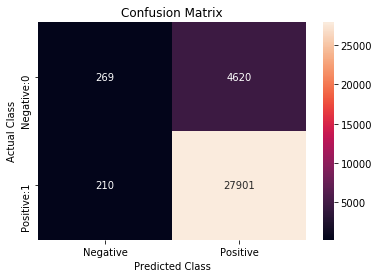

In [73]:
print("Heatmap of test confusion matrix")
import seaborn as sns
confusion_matrix_test_TFIDF = confusion_matrix(y_test, neigh_tfidf_brute.predict(X_test_tfidf_brute))

df_cm=pd.DataFrame(confusion_matrix_test_TFIDF,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

In [0]:
#Accuracy for KNN(brute force) model with TFIDF is 60.9%

## [3]Working With Avg W2V

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

### Applying KNN kd-tree on Avg W2V

In [0]:
#Training Data
# Training our own Word2Vec model using our own text corpus
i=0
list_of_sentance_train=[]
for sentance in X_train_kd:
    list_of_sentance_train.append(sentance.split())

In [77]:
# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need



# min_count = 5 considers only words that occured atleast 5 times
w2v_model_train=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
print(w2v_model_train.wv.most_similar('great'))
print('='*50)
print(w2v_model_train.wv.most_similar('worst'))
    

[('excellent', 0.9231005907058716), ('good', 0.9230788946151733), ('looking', 0.8783020973205566), ('quick', 0.8520298600196838), ('value', 0.8467196822166443), ('delish', 0.8430591225624084), ('works', 0.8424109816551208), ('vanillin', 0.841373085975647), ('tasty', 0.8405777215957642), ('tast', 0.8396354913711548)]
[('awful', 0.9899503588676453), ('bros', 0.9898895621299744), ('hate', 0.9896556735038757), ('berber', 0.9891136288642883), ('greens', 0.988629937171936), ('guayaki', 0.9879439473152161), ('type', 0.9878469705581665), ('jerky', 0.9876626133918762), ('simply', 0.987533688545227), ('nor', 0.9874781370162964)]


In [78]:
w2v_words_train = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])

number of words that occured minimum 5 times  6406
sample words  ['someone', 'puts', 'tabasco', 'sauce', 'eggs', 'breakfast', 'not', 'find', 'tiger', 'hot', 'flavorful', 'soup', 'kick', 'works', 'number', 'meals', 'think', 'anything', 'used', 'beans', 'chicken', 'beef', 'pork', 'tuna', 'salmon', 'tried', 'drinking', 'bottle', 'yet', 'trust', 'one', 'add', 'kitchen', 'others', 'better', 'careful', 'wind', 'sticky', 'mess', 'try', 'mix', 'liquid', 'prior', 'rice', 'mixture', 'tiny', 'jar', 'concentrated', 'yeast', 'extract']


In [0]:
#training

### Converting text into vectors using Avg W2V

#### Converting train data into vector form

In [80]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec_train = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words_train =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec_train = w2v_model_train.wv[word]
            sent_vec_train += vec_train
            cnt_words_train += 1
    if cnt_words_train != 0:
        sent_vec_train /= cnt_words_train
    sent_vectors_train.append(sent_vec_train)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|██████████| 8978/8978 [00:17<00:00, 511.00it/s]


(8978, 50)
[-0.62166555  0.48230727  0.8019969  -0.05290389  0.09487173 -0.18989685
 -0.12674396 -0.21550692  0.18079525 -0.29482872  0.74536585 -0.21097553
 -0.03324458 -1.25427958  0.04959794  0.40394421 -0.98898709 -0.1606317
  0.59245284 -0.6592589  -0.22987556  0.10794688  0.54130378 -0.84409611
  0.72028031 -0.20819487  0.39349584  0.1577451  -0.28270889  0.04125599
  0.43609833 -0.05628839 -0.41806687 -0.20025139  0.10086608  0.06273209
 -0.06685749 -0.15746365  1.15234059 -0.46407303  0.56366562  0.09335729
  0.44868698  0.09028297  0.12696747 -0.17937146 -0.74007994 -0.48933637
 -0.72183496  0.09016318]


#### Converting CV text data into vector form

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_cv=[]
for sentance in X_cv_kd:
    list_of_sentance_cv.append(sentance.split())

In [82]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|██████████| 4422/4422 [00:08<00:00, 497.14it/s]

(4422, 50)
[-5.25302520e-01  5.49330582e-01  6.11699127e-01  7.76923107e-05
  7.72147495e-02 -6.07564064e-02 -2.56057665e-01  7.03880764e-02
  1.14906586e-01 -1.27087154e-01  3.33134165e-01 -1.18786425e-01
 -4.43297637e-02 -9.48127919e-01  8.49868217e-02  1.96473455e-01
 -8.05805918e-01 -7.63467983e-02  5.37288922e-01 -3.61633309e-01
 -1.44995176e-01 -1.94946240e-02  1.99027821e-01 -5.37048727e-01
  3.71278534e-01 -2.53568196e-01  1.27408705e-01  3.20480465e-01
  1.33874034e-01  6.66828753e-02  1.46709499e-01  1.19943627e-01
 -4.32373398e-02  7.24299083e-03  4.01102444e-01  1.51931036e-01
 -7.64147301e-02  1.49194525e-01  6.56342990e-01 -3.85530515e-01
  4.55051663e-01  1.84750525e-01  2.17820080e-01  3.20543987e-01
  1.90409122e-01 -5.41891361e-02 -6.93356486e-01 -4.92526616e-01
 -6.01551542e-01  7.35495570e-02]


#### Converting test data into vector form

In [0]:
i=0
list_of_sentance_test=[]
for sentance in X_test_kd:
    list_of_sentance_test.append(sentance.split())

In [84]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|██████████| 6600/6600 [00:13<00:00, 486.66it/s]

(6600, 50)
[-0.37689233  0.67485332  0.59366895  0.02842227 -0.03290507 -0.27946095
 -0.45147211  0.47662011  0.13692747 -0.22923954  0.02614932  0.03392608
  0.51767136 -0.97991804 -0.3999368  -0.23327693 -1.00869949 -0.25453024
  0.33634788 -0.53040193 -0.05393167 -0.18483522  0.46143725 -0.34895475
  0.15741653 -0.52535305  0.38748047  0.31199329  0.10352285  0.06315424
 -0.30279839  0.2085872  -0.03625376 -0.13657935  0.3229223   0.18181889
  0.17622956  0.47008987  0.93280368 -0.47130577  0.58475386  0.31854829
  0.23693623  0.39437471  0.01430326 -0.40480112 -0.66038306 -0.88850141
 -0.25027865  0.65718517]


### Applying Gridsearch to do hyperparameter tuning

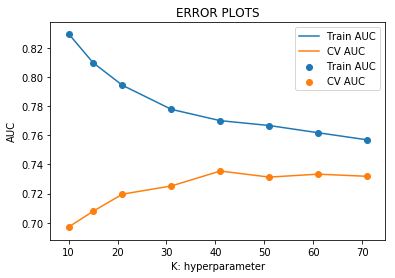

In [85]:
train_auc = []
cv_auc = []
K = [10, 15, 21, 31, 41, 51,61,71]

for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i ,algorithm='kd_tree',n_jobs=-1)
    neigh.fit(sent_vectors_train, y_train_kd)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(sent_vectors_train)[:,1]
    y_cv_pred =  neigh.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train_kd,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv_kd, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Testing with test data

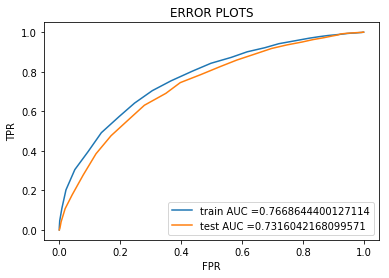

Train confusion matrix
[[  37 1374]
 [  27 7540]]
Test confusion matrix
[[  28  966]
 [  14 5592]]


In [86]:
#Testing with test data

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh_avgw2v_kd = KNeighborsClassifier(n_neighbors=52 ,n_jobs=-1,algorithm='kd_tree')
neigh_avgw2v_kd.fit(sent_vectors_train, y_train_kd)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

#converting sparse matrices into dense as Kd-tree algo takes dense matrices

#X_test_tfidf_kd=X_test_tfidf_kd.toarray()

train_fpr_tfidf, train_tpr_tfidf, thresholds_tfidf = roc_curve(y_train_kd, neigh_avgw2v_kd.predict_proba(sent_vectors_train)[:,1])
test_fpr_tfidf, test_tpr_tfidf, thresholds_tfidf = roc_curve(y_test_kd, neigh_avgw2v_kd.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr_tfidf, train_tpr_tfidf, label="train AUC ="+str(auc(train_fpr_tfidf, train_tpr_tfidf)))
plt.plot(test_fpr_tfidf, test_tpr_tfidf, label="test AUC ="+str(auc(test_fpr_tfidf, test_tpr_tfidf)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train_kd, neigh_avgw2v_kd.predict(sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test_kd, neigh_avgw2v_kd.predict(sent_vectors_test)))

Heatmap of train confusion matrix


Text(33.0, 0.5, 'Actual Class')

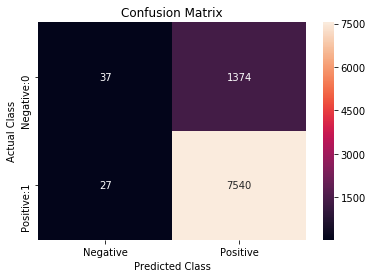

In [88]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_W2V = confusion_matrix(y_train_kd, neigh_avgw2v_kd.predict(sent_vectors_train))

df_cm=pd.DataFrame(confusion_matrix_train_W2V,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of test confusion matrix


Text(33.0, 0.5, 'Actual Class')

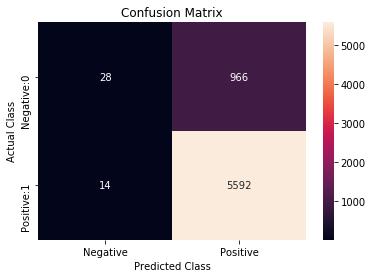

In [89]:
print("Heatmap of test confusion matrix")
import seaborn as sns
confusion_matrix_test_W2V = confusion_matrix(y_test_kd, neigh_avgw2v_kd.predict(sent_vectors_test))

df_cm=pd.DataFrame(confusion_matrix_test_W2V,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

In [0]:
#Accuracy for KNN(kd-tree) model with AvgW2V is 73.16%

### Applying KNN brute force on Avg W2V

####  Converting train data into vector form

In [0]:
#Applying brute force on Avgw2v

i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())


In [92]:
# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need



# min_count = 5 considers only words that occured atleast 5 times
w2v_model_train=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
print(w2v_model_train.wv.most_similar('great'))
print('='*50)
print(w2v_model_train.wv.most_similar('worst'))

[('terrific', 0.8289519548416138), ('good', 0.8242506384849548), ('wonderful', 0.8236252665519714), ('excellent', 0.8181947469711304), ('fantastic', 0.8122857809066772), ('awesome', 0.8120837807655334), ('perfect', 0.7792816162109375), ('amazing', 0.7389242053031921), ('incredible', 0.7264012694358826), ('fabulous', 0.7245001792907715)]
[('best', 0.7830919623374939), ('greatest', 0.7060685753822327), ('nastiest', 0.6865239143371582), ('closest', 0.6665735840797424), ('tastiest', 0.6630874276161194), ('disgusting', 0.6393887996673584), ('cutest', 0.6291120648384094), ('horrible', 0.6145334839820862), ('encountered', 0.6082696914672852), ('honestly', 0.6014037728309631)]


In [93]:
w2v_words_train = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])

number of words that occured minimum 5 times  13110
sample words  ['two', 'tiny', 'chihuahua', 'love', 'itty', 'bitty', 'buddy', 'treats', 'hard', 'find', 'not', 'many', 'pet', 'stores', 'best', 'treat', 'ever', 'new', 'favorite', 'could', 'quite', 'drink', 'much', 'water', 'doctor', 'recommended', 'pour', 'packet', 'tea', 'no', 'problems', 'great', 'flavor', 'local', 'grocer', 'kept', 'running', 'one', 'recommend', 'lover', 'good', 'mustard', 'looking', 'something', 'right', 'balance', 'hot', 'sweet', 'liked', 'made']


In [94]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec_train = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words_train =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec_train = w2v_model_train.wv[word]
            sent_vec_train += vec_train
            cnt_words_train += 1
    if cnt_words_train != 0:
        sent_vec_train /= cnt_words_train
    sent_vectors_train.append(sent_vec_train)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|██████████| 44890/44890 [01:44<00:00, 431.62it/s]

(44890, 50)
[-0.68315093  0.35023282 -0.41431159 -0.4151961   1.00404422  0.03408376
  0.49805391  0.42131169  0.38643222  0.08497739  0.09935225 -0.2218789
  0.44946839 -1.42853684  0.29201763  0.68258452 -0.37091655  0.76016611
 -0.45848476 -0.00828925  0.17633877  0.32803263  0.80785526 -0.18580251
  0.23028154 -0.15172906  0.19866744  0.71977887  0.02935736 -0.47722835
 -0.5273591   0.26545971  0.32783224 -0.14742535  0.45206275  0.15353146
  0.71224745 -0.18132822  0.79648542 -0.16730414  0.27858109  0.1121821
  0.73859245  0.82058651 -0.76502351  0.51677093 -0.39355889 -0.24203409
  0.21199592  0.47513481]


####  Converting CV data into vector form

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [96]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|██████████| 22110/22110 [00:50<00:00, 434.81it/s]

(22110, 50)
[-0.23974564  0.85062449  0.27216482 -0.23696456  0.54003964 -0.75884246
  0.16426752  0.47345571  0.10295631  0.56957713  0.20050378  0.58084252
 -0.33303825 -0.39525413  1.12436349  0.12880258 -0.31123021  0.37836052
  0.26705761 -0.96294278  0.83037593  0.1164472   0.52026666  0.86310297
  0.20981404 -1.06079409 -0.37242337  0.14012097  0.28502111 -0.1059576
 -0.86040984  0.2155176  -0.35845661 -0.33295766  1.01192509  0.42534854
  0.52132055 -0.28299947  1.37032006 -0.50357717 -0.92621494  0.67513085
 -0.14975056  0.05281757 -0.32119853  0.47718127 -0.03954856 -1.04668604
  0.13896625  0.88397622]


####  Converting test data into vector form

In [0]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [98]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|██████████| 33000/33000 [01:15<00:00, 439.20it/s]

(33000, 50)
[-0.33647224  0.16753667  0.30355603  0.09865604  0.76446923  0.17654617
  0.27306983 -0.44288121  0.01647811  0.33502324 -0.57687242 -0.87397725
 -0.33649408 -1.64784437  0.54191229 -1.02286959  0.04722573  0.40670206
 -0.47936705 -0.72496772  0.85699156  0.01234939 -1.08713402 -0.8092885
 -0.03967168 -0.70808248  0.40762726  0.11364686  0.0729832  -0.53643914
 -0.01171657 -0.46174066  0.1368437  -0.26160212  1.09257075  0.89255228
 -0.1344157  -0.57082637  0.47530122 -0.18430574 -0.36315182  0.99407393
  0.64983426 -0.18118572  0.3226354  -0.27936124  0.05336635 -0.28506522
  0.49531644  1.17899471]


###  Applying Gridsearch to do hyperparameter tuning

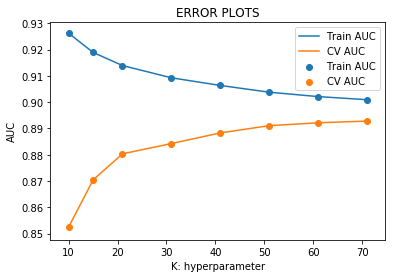

In [99]:
train_auc = []
cv_auc = []
K = [10, 15, 21, 31, 41, 51,61,71]

for i in K:
    neigh_avgw2v_brute = KNeighborsClassifier(n_neighbors=i ,algorithm='brute')
    neigh_avgw2v_brute.fit(sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh_avgw2v_brute.predict_proba(sent_vectors_train)[:,1]
    y_cv_pred =  neigh_avgw2v_brute.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Testing with test data

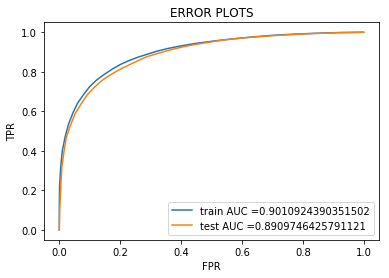

Train confusion matrix
[[ 1542  5112]
 [  380 37856]]
Test confusion matrix
[[ 1046  3843]
 [  287 27824]]


In [100]:
#Testing with Test Data

neigh_avgw2v_brute = KNeighborsClassifier(n_neighbors=70 ,algorithm='brute')
neigh_avgw2v_brute.fit(sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

#converting sparse matrices into dense as Kd-tree algo takes dense matrices

#X_test_tfidf_kd=X_test_tfidf_kd.toarray()

train_fpr_tfidf, train_tpr_tfidf, thresholds_tfidf = roc_curve(y_train, neigh_avgw2v_brute.predict_proba(sent_vectors_train)[:,1])
test_fpr_tfidf, test_tpr_tfidf, thresholds_tfidf = roc_curve(y_test, neigh_avgw2v_brute.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr_tfidf, train_tpr_tfidf, label="train AUC ="+str(auc(train_fpr_tfidf, train_tpr_tfidf)))
plt.plot(test_fpr_tfidf, test_tpr_tfidf, label="test AUC ="+str(auc(test_fpr_tfidf, test_tpr_tfidf)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh_avgw2v_brute.predict(sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh_avgw2v_brute.predict(sent_vectors_test)))

Heatmap of train confusion matrix


Text(33.0, 0.5, 'Actual Class')

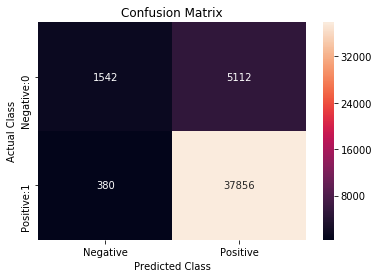

In [102]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_W2V = confusion_matrix(y_train, neigh_avgw2v_brute.predict(sent_vectors_train))

df_cm=pd.DataFrame(confusion_matrix_train_W2V,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of test confusion matrix


Text(33.0, 0.5, 'Actual Class')

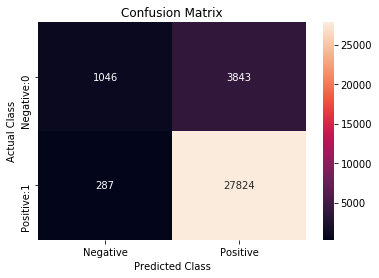

In [103]:
print("Heatmap of test confusion matrix")
import seaborn as sns
confusion_matrix_test_W2V = confusion_matrix(y_test, neigh_avgw2v_brute.predict(sent_vectors_test))

df_cm=pd.DataFrame(confusion_matrix_test_W2V,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

In [0]:
#Accuracy for KNN(brute force) model with AvgW2V is 72.02%

## [4]Working With TFIDF Weighted W2V

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(X_train_kd)
tf_idf_matrix_cv = model.transform(X_cv_kd)
tf_idf_matrix_test = model.transform(X_test_kd)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

### Applying KNN kd-tree on TFIDF Weighted W2V

#### Converting train data into vector form

In [0]:
i=0
list_of_sentance_train=[]
for sentance in X_train_kd:
    list_of_sentance_train.append(sentance.split())

In [119]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_train=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
print(w2v_model_train.wv.most_similar('great'))
print('='*50)
print(w2v_model_train.wv.most_similar('worst'))

[('good', 0.9060181975364685), ('excellent', 0.8965076208114624), ('tasty', 0.8764246702194214), ('looking', 0.8732441663742065), ('definitely', 0.8577439188957214), ('wonderful', 0.8469069004058838), ('quite', 0.8468934893608093), ('recomend', 0.843437135219574), ('dare', 0.8430204391479492), ('reccommend', 0.8400803208351135)]
[('guayaki', 0.98931884765625), ('simply', 0.9892967939376831), ('jamaican', 0.9884536266326904), ('variety', 0.9883777499198914), ('absolute', 0.9874720573425293), ('accustomed', 0.9868610501289368), ('hands', 0.9868210554122925), ('ultra', 0.9862350821495056), ('american', 0.9852244257926941), ('wild', 0.9850105047225952)]


In [121]:
w2v_words_train = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])

number of words that occured minimum 5 times  6406
sample words  ['someone', 'puts', 'tabasco', 'sauce', 'eggs', 'breakfast', 'not', 'find', 'tiger', 'hot', 'flavorful', 'soup', 'kick', 'works', 'number', 'meals', 'think', 'anything', 'used', 'beans', 'chicken', 'beef', 'pork', 'tuna', 'salmon', 'tried', 'drinking', 'bottle', 'yet', 'trust', 'one', 'add', 'kitchen', 'others', 'better', 'careful', 'wind', 'sticky', 'mess', 'try', 'mix', 'liquid', 'prior', 'rice', 'mixture', 'tiny', 'jar', 'concentrated', 'yeast', 'extract']


In [122]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 8978/8978 [02:01<00:00, 74.09it/s]


#### Converting cv data into vector form

In [0]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv_kd:
    list_of_sentance_cv.append(sentance.split())

In [124]:
#cv data

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 4422/4422 [00:58<00:00, 75.54it/s]


#### Converting test data into vector form

In [0]:
i=0
list_of_sentance_test=[]
for sentance in X_test_kd:
    list_of_sentance_test.append(sentance.split())

In [126]:
#test data

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 6600/6600 [01:29<00:00, 73.50it/s]


###  Applying Gridsearch to do hyperparameter tuning

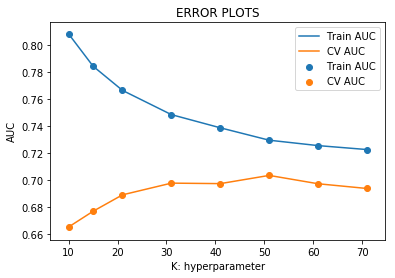

In [127]:
train_auc = []
cv_auc = []
K = [10, 15, 21, 31, 41, 51,61,71]

for i in K:
    neigh_avgtfidf_kd = KNeighborsClassifier(n_neighbors=i ,algorithm='kd_tree')
    neigh_avgtfidf_kd.fit(tfidf_sent_vectors_train, y_train_kd)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh_avgtfidf_kd.predict_proba(tfidf_sent_vectors_train)[:,1]
    y_cv_pred =  neigh_avgtfidf_kd.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train_kd,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv_kd, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Testing with test data

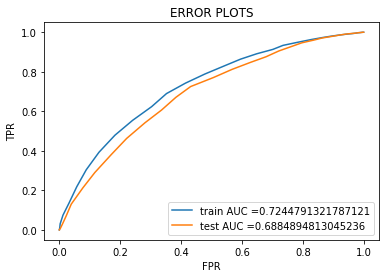

Train confusion matrix
[[   1 1410]
 [   0 7567]]
Test confusion matrix
[[   2  992]
 [   1 5605]]


In [129]:

neigh_avgtfidf_kd = KNeighborsClassifier(n_neighbors=65 ,algorithm='kd_tree')
neigh_avgtfidf_kd.fit(tfidf_sent_vectors_train, y_train_kd)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

#converting sparse matrices into dense as Kd-tree algo takes dense matrices

#X_test_tfidf_kd=X_test_tfidf_kd.toarray()

train_fpr_tfidf, train_tpr_tfidf, thresholds_tfidf = roc_curve(y_train_kd, neigh_avgtfidf_kd.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr_tfidf, test_tpr_tfidf, thresholds_tfidf = roc_curve(y_test_kd, neigh_avgtfidf_kd.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr_tfidf, train_tpr_tfidf, label="train AUC ="+str(auc(train_fpr_tfidf, train_tpr_tfidf)))
plt.plot(test_fpr_tfidf, test_tpr_tfidf, label="test AUC ="+str(auc(test_fpr_tfidf, test_tpr_tfidf)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train_kd, neigh_avgtfidf_kd.predict(tfidf_sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test_kd, neigh_avgtfidf_kd.predict(tfidf_sent_vectors_test)))

Heatmap of train confusion matrix


Text(33.0, 0.5, 'Actual Class')

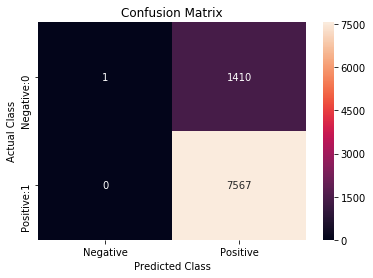

In [131]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_AvgTFIDF = confusion_matrix(y_train_kd, neigh_avgtfidf_kd.predict(tfidf_sent_vectors_train))

df_cm=pd.DataFrame(confusion_matrix_train_AvgTFIDF,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of test confusion matrix


Text(33.0, 0.5, 'Actual Class')

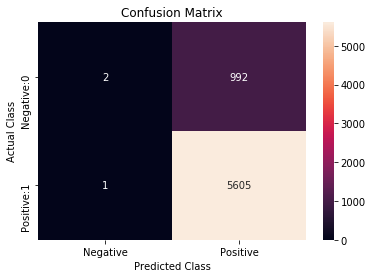

In [132]:
print("Heatmap of test confusion matrix")
import seaborn as sns
confusion_matrix_test_AvgTFIDF = confusion_matrix(y_test_kd, neigh_avgtfidf_kd.predict(tfidf_sent_vectors_test))

df_cm=pd.DataFrame(confusion_matrix_test_AvgTFIDF,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

In [0]:
#Accuracy for KNN(kd-tree) model with TFIDF WeightedW2V is 68.8%

### Applying KNN brute force on TFIDF Weighted W2V

In [0]:
#Applying brute algorithm
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(X_train)
tf_idf_matrix_cv = model.transform(X_cv)
tf_idf_matrix_test = model.transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

#### Converting train data into vector form

In [0]:


i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [135]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_train=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
print(w2v_model_train.wv.most_similar('great'))
print('='*50)
print(w2v_model_train.wv.most_similar('worst'))

[('terrific', 0.8224151134490967), ('wonderful', 0.8120076656341553), ('excellent', 0.8063195943832397), ('good', 0.7921974062919617), ('awesome', 0.7910985350608826), ('fantastic', 0.7756904363632202), ('perfect', 0.7691740393638611), ('amazing', 0.7359341979026794), ('fabulous', 0.7279670238494873), ('incredible', 0.7160531878471375)]
[('best', 0.7592031359672546), ('nastiest', 0.7285611033439636), ('greatest', 0.7262065410614014), ('displeasure', 0.6703755855560303), ('closest', 0.6692342162132263), ('horrible', 0.6645740866661072), ('awful', 0.6531530022621155), ('tastiest', 0.6440859436988831), ('disgusting', 0.6228762269020081), ('terrible', 0.6126399040222168)]


In [136]:
w2v_words_train = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])

number of words that occured minimum 5 times  13110
sample words  ['two', 'tiny', 'chihuahua', 'love', 'itty', 'bitty', 'buddy', 'treats', 'hard', 'find', 'not', 'many', 'pet', 'stores', 'best', 'treat', 'ever', 'new', 'favorite', 'could', 'quite', 'drink', 'much', 'water', 'doctor', 'recommended', 'pour', 'packet', 'tea', 'no', 'problems', 'great', 'flavor', 'local', 'grocer', 'kept', 'running', 'one', 'recommend', 'lover', 'good', 'mustard', 'looking', 'something', 'right', 'balance', 'hot', 'sweet', 'liked', 'made']


In [137]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 44890/44890 [17:31<00:00, 42.67it/s]


#### Converting cv data into vector form

In [0]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [139]:
#cv data

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 22110/22110 [08:27<00:00, 43.54it/s]


#### Converting test data into vector form

In [0]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [141]:
#test data

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 33000/33000 [12:34<00:00, 43.75it/s]


### Applying Gridsearch to do hyperparameter tuning

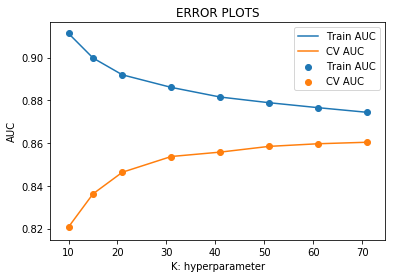

In [142]:
train_auc = []
cv_auc = []
K = [10, 15, 21, 31, 41, 51,61,71]

for i in K:
    neigh_avgtfidf_brute = KNeighborsClassifier(n_neighbors=i ,algorithm='brute')
    neigh_avgtfidf_brute.fit(tfidf_sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh_avgtfidf_brute.predict_proba(tfidf_sent_vectors_train)[:,1]
    y_cv_pred =  neigh_avgtfidf_brute.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Testing with test data

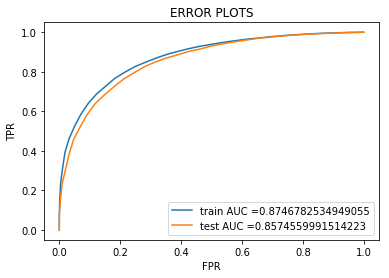

Train confusion matrix
[[ 1139  5515]
 [  306 37930]]
Test confusion matrix
[[  797  4092]
 [  232 27879]]


In [143]:
#Testing with Test data

neigh_avgtfidf_brute = KNeighborsClassifier(n_neighbors=70 ,algorithm='brute')
neigh_avgtfidf_brute.fit(tfidf_sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

#converting sparse matrices into dense as Kd-tree algo takes dense matrices

#X_test_tfidf_kd=X_test_tfidf_kd.toarray()

train_fpr_tfidf, train_tpr_tfidf, thresholds_tfidf = roc_curve(y_train, neigh_avgtfidf_brute.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr_tfidf, test_tpr_tfidf, thresholds_tfidf = roc_curve(y_test, neigh_avgtfidf_brute.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr_tfidf, train_tpr_tfidf, label="train AUC ="+str(auc(train_fpr_tfidf, train_tpr_tfidf)))
plt.plot(test_fpr_tfidf, test_tpr_tfidf, label="test AUC ="+str(auc(test_fpr_tfidf, test_tpr_tfidf)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh_avgtfidf_brute.predict(tfidf_sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh_avgtfidf_brute.predict(tfidf_sent_vectors_test)))

Heatmap of train confusion matrix


Text(33.0, 0.5, 'Actual Class')

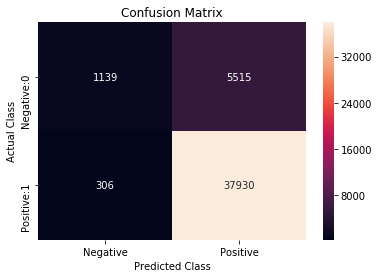

In [146]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_AvgTFIDF = confusion_matrix(y_train, neigh_avgtfidf_brute.predict(tfidf_sent_vectors_train))

df_cm=pd.DataFrame(confusion_matrix_train_AvgTFIDF,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of test confusion matrix


Text(33.0, 0.5, 'Actual Class')

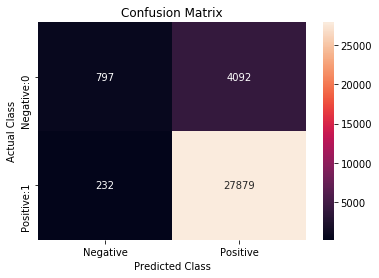

In [148]:
print("Heatmap of test confusion matrix")
import seaborn as sns
confusion_matrix_test_AvgTFIDF = confusion_matrix(y_test, neigh_avgtfidf_brute.predict(tfidf_sent_vectors_test))

df_cm=pd.DataFrame(confusion_matrix_test_AvgTFIDF,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

In [0]:
#Accuracy for KNN(brute force) model with TFIDF weightedW2V is 85.7%

# Conclusion

In [149]:
from prettytable import PrettyTable
X=PrettyTable()
X.field_names=["Model_Name","Train_Accuracy","Test_Acuracy","Optimal_K"]
X.add_row(["KNN(Kd-tree) With BOW", 79.1, 74.7, 50])
X.add_row(["KNN(brute) With BOW", 79.9, 75.7, 45])
X.add_row(["KNN(Kd-tree) With TFIDF", 83.5, 77.5, 60])
X.add_row(["KNN(brute) With TFIDF", 82.1, 60.3, 10])
X.add_row(["KNN(Kd-tree) With AvgW2V", 76.6, 73.1, 52])
X.add_row(["KNN(brute) With AvgW2V", 90.1, 89.09, 70])
X.add_row(["KNN(Kd-tree) With TFIDFWeightedW2V", 72.4, 68.8, 65])
X.add_row(["KNN(brute) With TFIDFWeightedW2V", 87.4, 85.7, 70])
print(X)

+------------------------------------+----------------+--------------+-----------+
|             Model_Name             | Train_Accuracy | Test_Acuracy | Optimal_K |
+------------------------------------+----------------+--------------+-----------+
|       KNN(Kd-tree) With BOW        |      79.1      |     74.7     |     50    |
|        KNN(brute) With BOW         |      79.9      |     75.7     |     45    |
|      KNN(Kd-tree) With TFIDF       |      83.5      |     77.5     |     60    |
|       KNN(brute) With TFIDF        |      82.1      |     60.3     |     10    |
|      KNN(Kd-tree) With AvgW2V      |      76.6      |     73.1     |     52    |
|       KNN(brute) With AvgW2V       |      90.1      |    89.09     |     70    |
| KNN(Kd-tree) With TFIDFWeightedW2V |      72.4      |     68.8     |     65    |
|  KNN(brute) With TFIDFWeightedW2V  |      87.4      |     85.7     |     70    |
+------------------------------------+----------------+--------------+-----------+


#### Observation:

Average word2vec with knn(brute force algorithm) gives test accuracy of 89.09% which is maximum among other algorithms.
but KNN may not be best algorithm for finding polarity as computation time taken to calculate distances is much higher.